In [204]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

import torch
import torch_geometric as tg

sns.set()

In [205]:
df = pd.read_csv("Test_DGA_network.tsv", sep="\t", names=["disease", "gene"])

In [206]:
df.head()

,disease,gene
0,C0001418,8289
1,C0011853,7040
2,C0009375,1956
3,C0279626,4853
4,C0205642,7422


In [207]:
df.gene = df.gene.astype(str)

In [208]:
G = nx.Graph()
G.add_nodes_from(df.disease, bipartite="disease", y=0)
G.add_nodes_from(df.gene, bipartite="gene", y=1)
G.add_edges_from(zip(df.disease.tolist(), df.gene.tolist()))

# G = nx.from_pandas_edgelist(df, source="disease", target="gene")


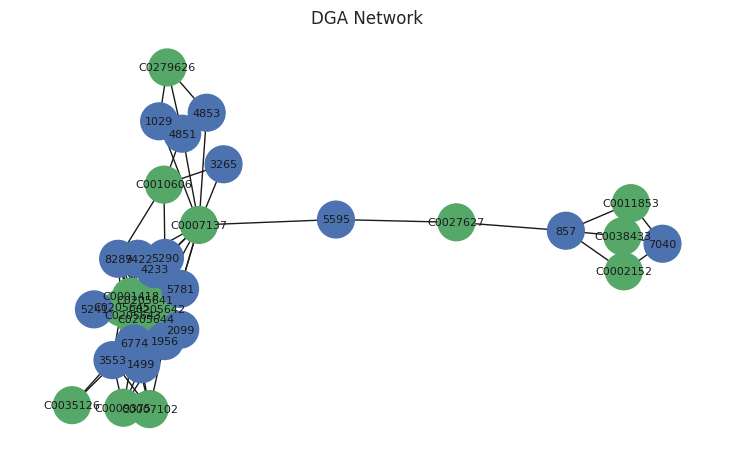

In [352]:
plt.figure(1, figsize=(8, 5))
plt.title("DGA Network")
plt.tight_layout()

color = nx.bipartite.color(G)
color_dict = {"disease": "g", "gene":"b"}
color_list = [color_dict[i[1]] for i in G.nodes.data("bipartite")]
nx.draw(G, pos=nx.spring_layout(G, seed=10), with_labels=True, node_color=color_list, node_size=700, font_size=8)
# nx.draw(G, pos=nx.shell_layout(G))

In [210]:
data = tg.utils.from_networkx(G)

In [211]:
print(data.edge_index.shape)

torch.Size([2, 204])


In [212]:
print(data.is_directed())
print(data.has_isolated_nodes())
print(data.has_self_loops())


False
False
False


In [213]:
data

Data(edge_index=[2, 204], y=[34], bipartite=[34], num_nodes=34)

Split training and testing set

- just split it (pseudo)randomly

In [379]:
import random

SEED = 10
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

train_mask = torch.rand(34) > 0.75
print(train_mask)

tensor([False, False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
         True,  True,  True, False])


In [380]:
data.train_mask = torch.Tensor(train_mask)
data.x = torch.eye(34)  # identitiy matrix for node features (doesnt do anything)

## GCN

In [381]:
def visualize(h, color, epoch=None, loss=None, accuracy=None):
    plt.figure(figsize=(5, 5))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None and accuracy['train'] is not None and accuracy['val'] is not None:
            plt.xlabel((f'Epoch: {epoch}, Loss: {loss.item():.4f} \n'
                       f'Training Accuracy: {accuracy["train"]*100:.2f}% \n'
                        f' Validation Accuracy: {accuracy["val"]*100:.2f}%'),
                       fontsize=16)
    else:
        nx.draw_networkx(h, pos=nx.spring_layout(h, seed=10), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()


In [427]:
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(SEED)
        self.gcn1 = GCNConv(34, 4)
        # self.gcn1 = GCNConv(4, 3)
        self.gcn2 = GCNConv(4, 3)
        self.out = Linear(3, 2)

    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index).relu()
        h = self.gcn2(h, edge_index).relu()
        out = self.out(h)
        return out, h


model = GCN()
print(model)


GCN(
  (gcn1): GCNConv(34, 4)
  (gcn2): GCNConv(4, 3)
  (out): Linear(in_features=3, out_features=2, bias=True)
)


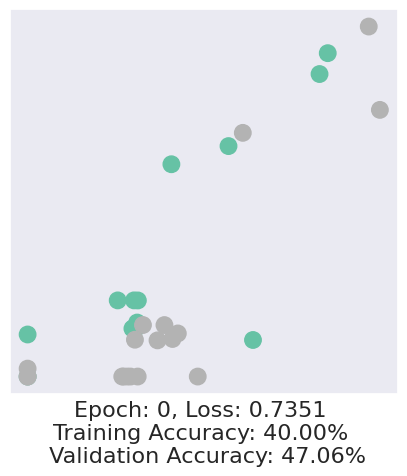

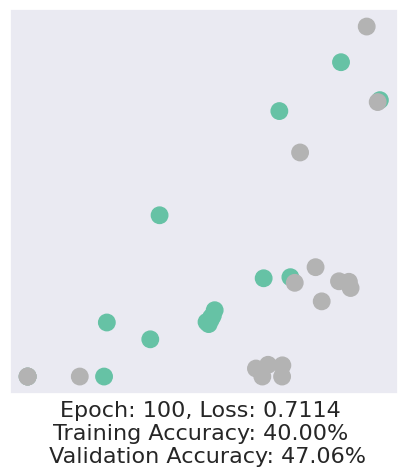

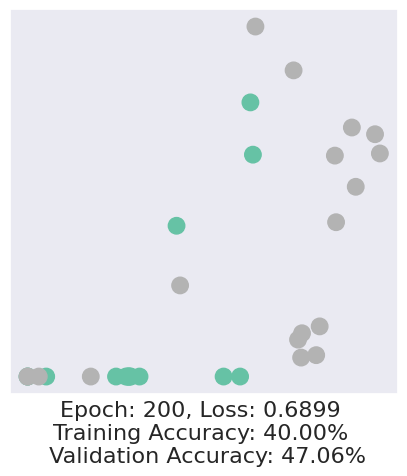

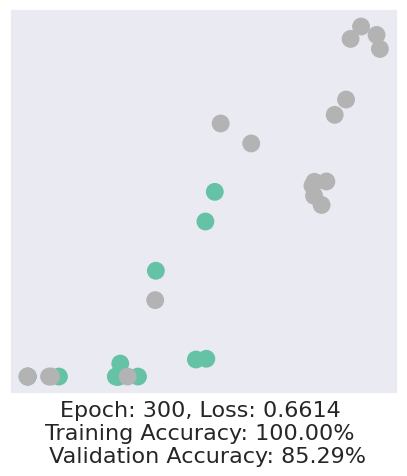

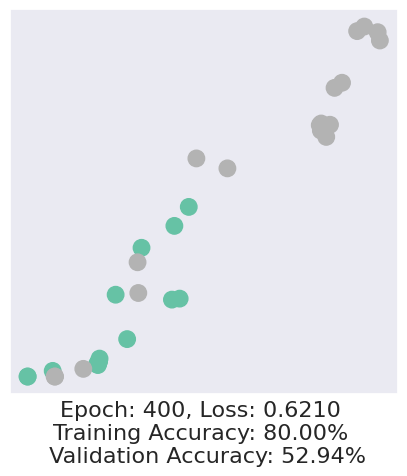

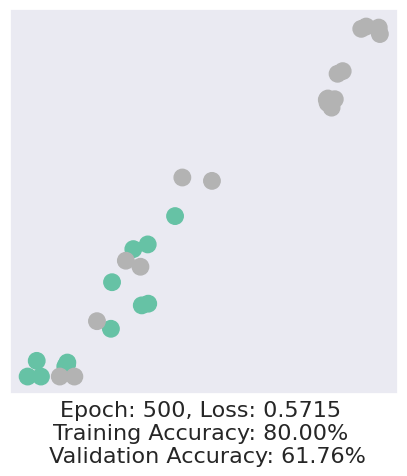

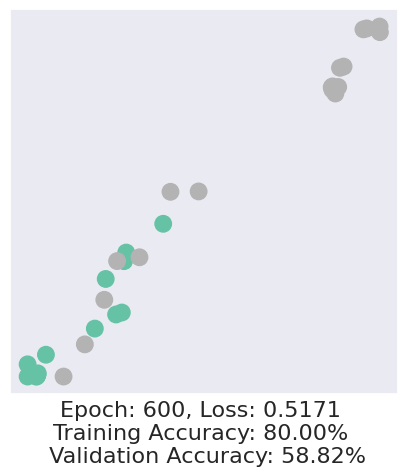

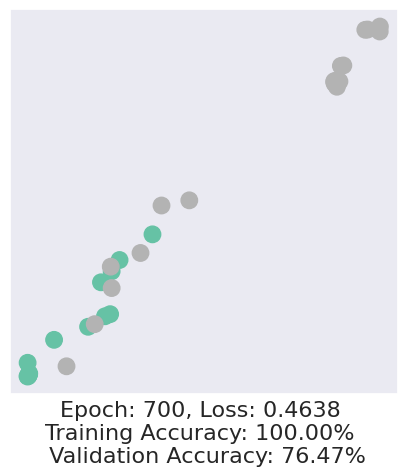

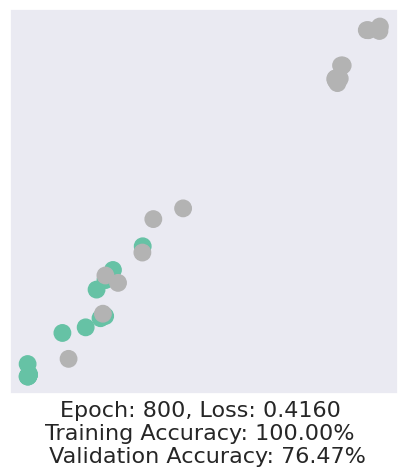

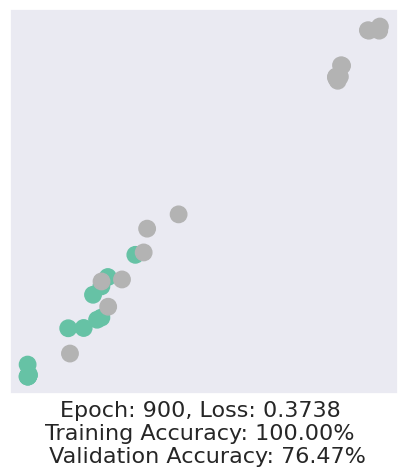

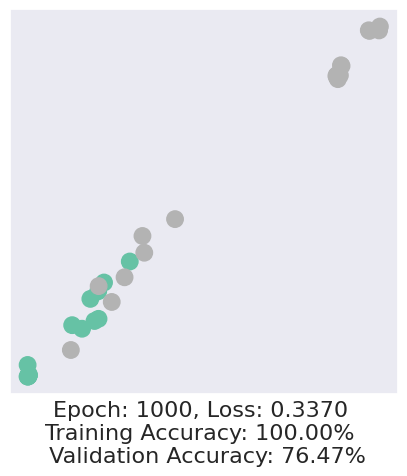

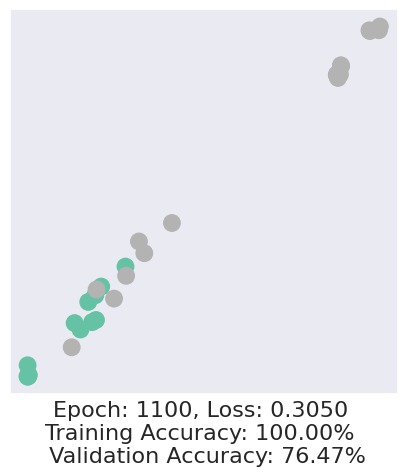

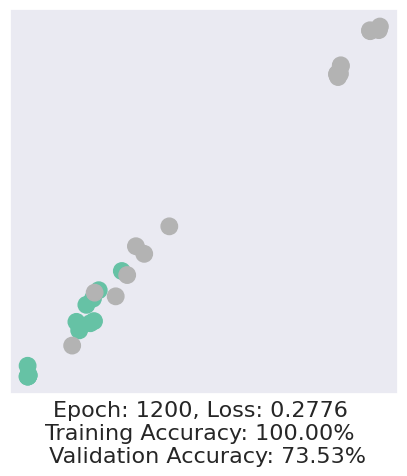

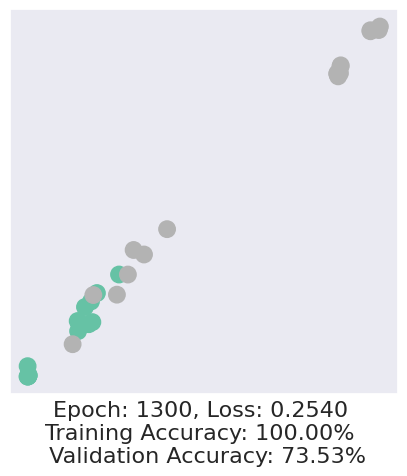

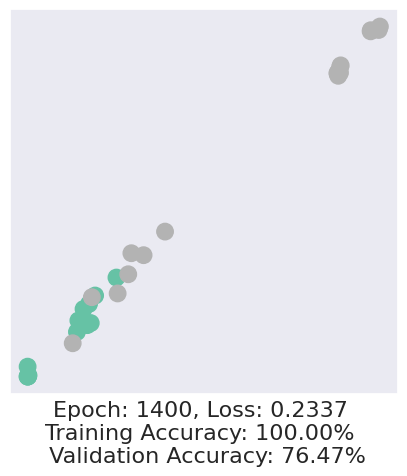

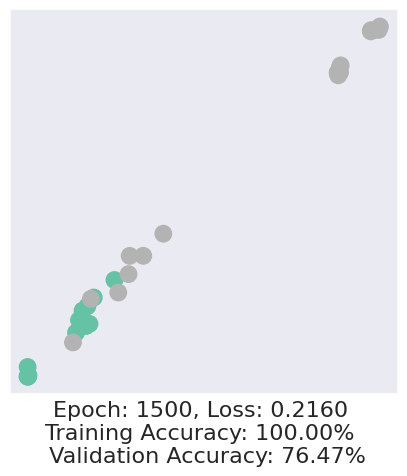

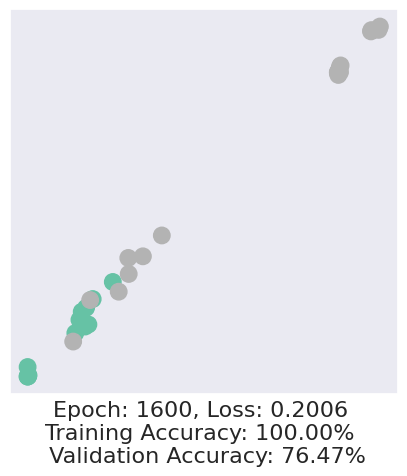

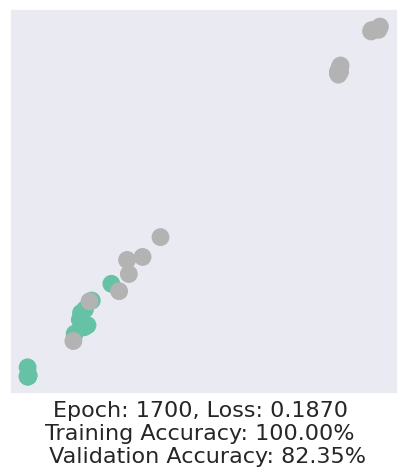

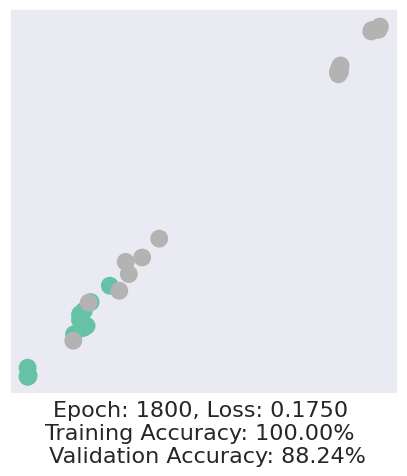

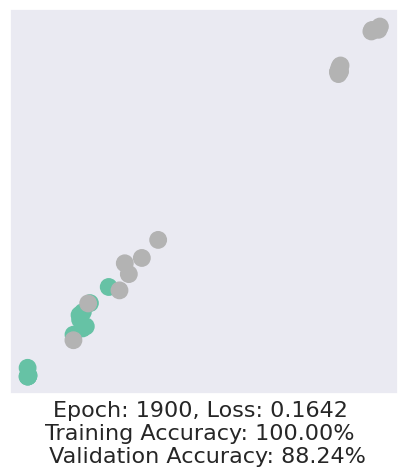

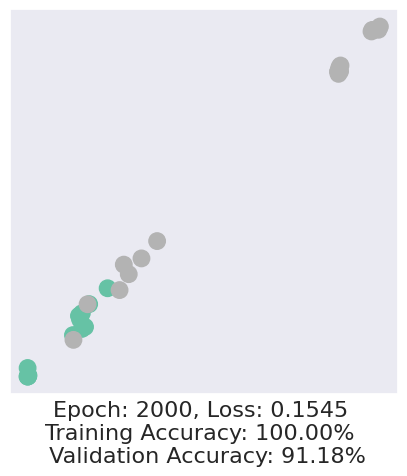

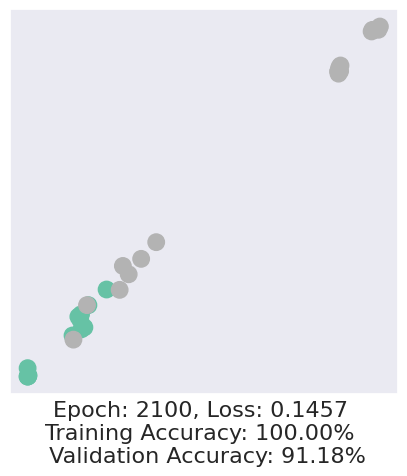

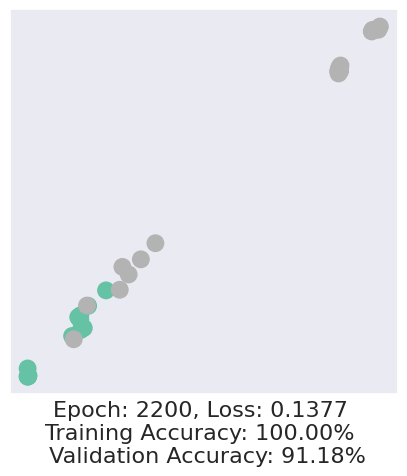

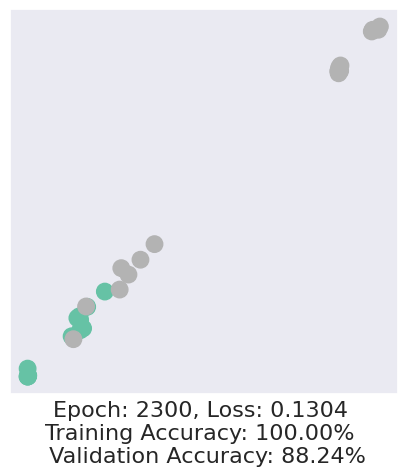

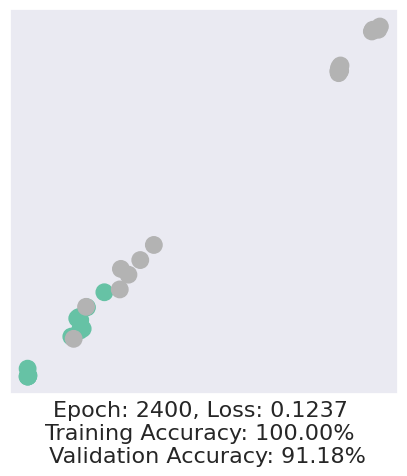

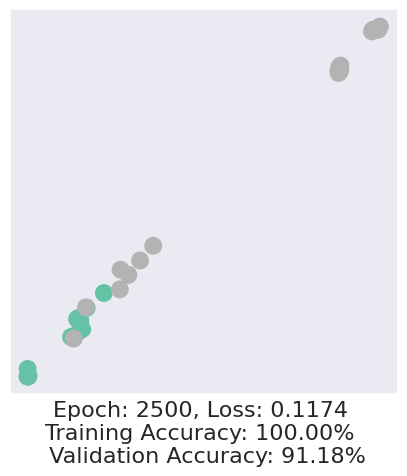

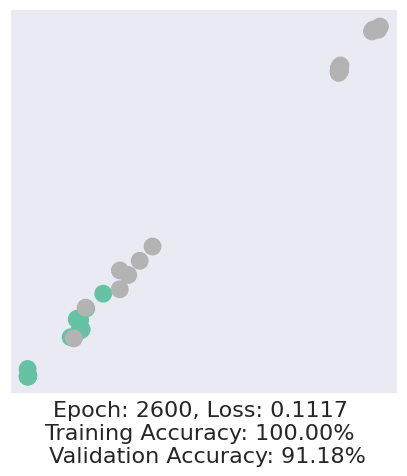

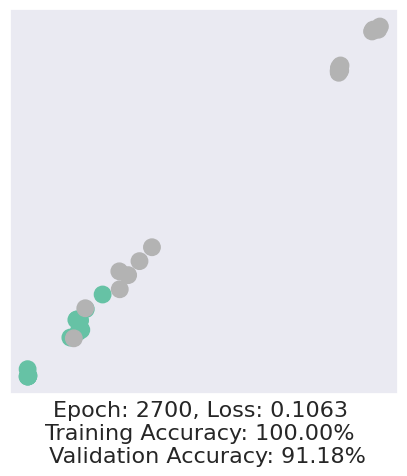

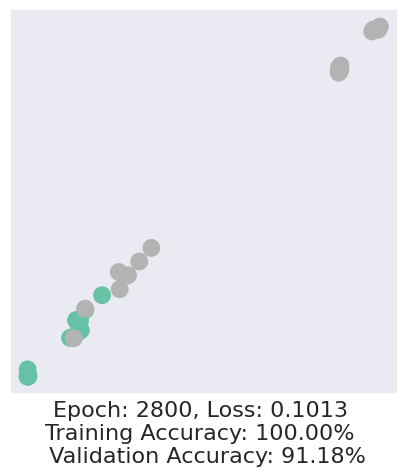

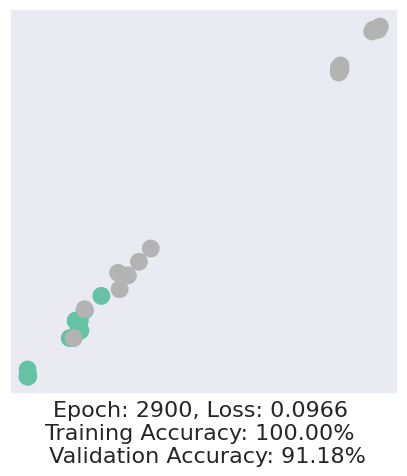

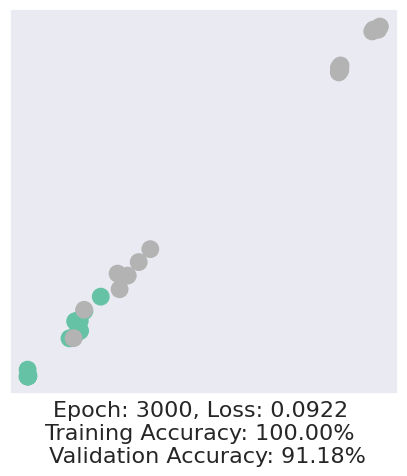

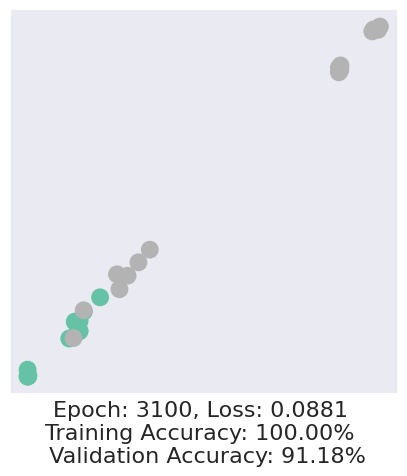

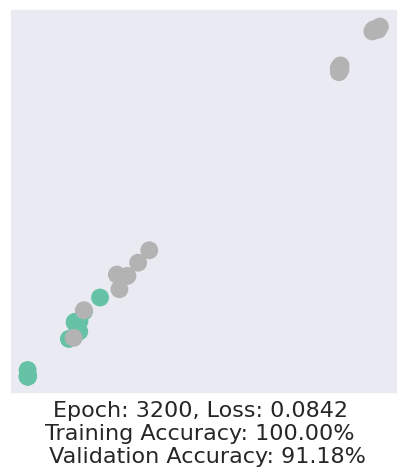

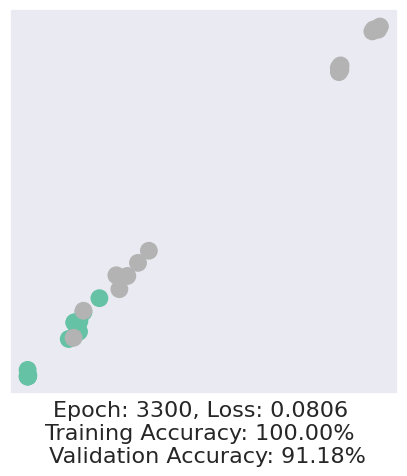

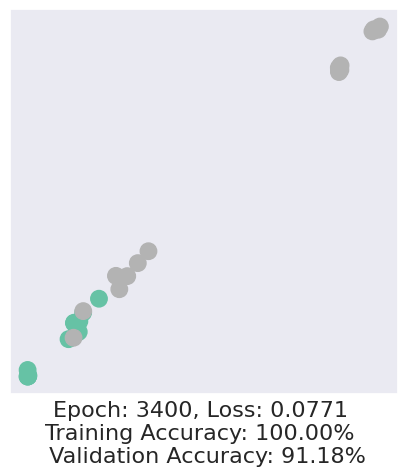

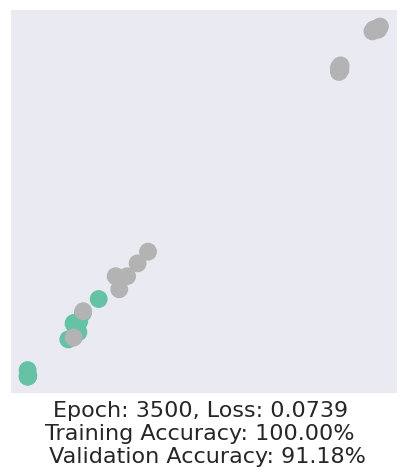

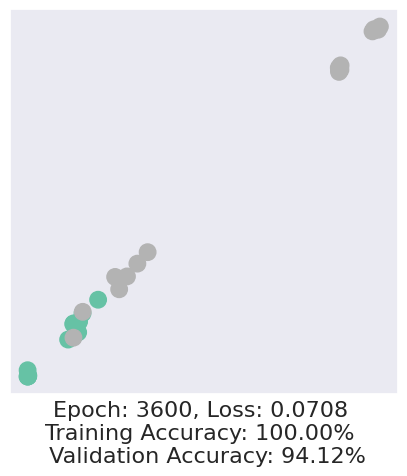

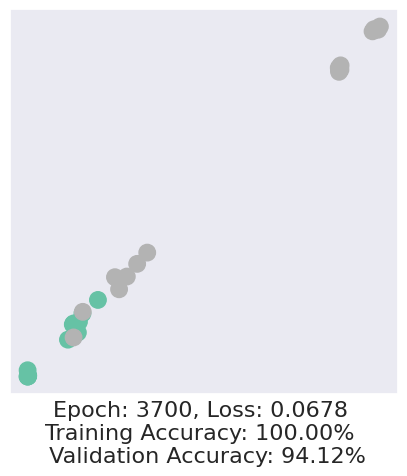

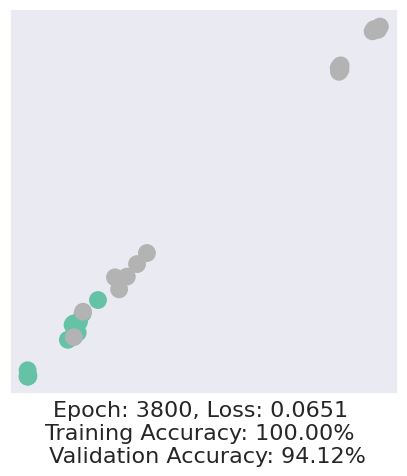

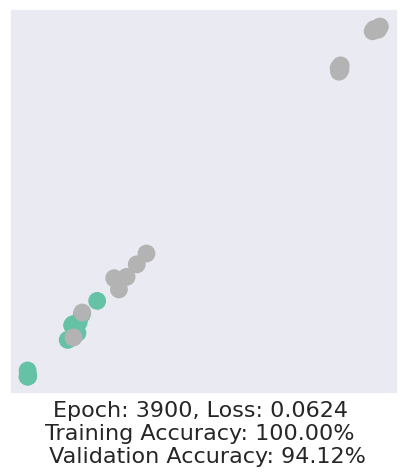

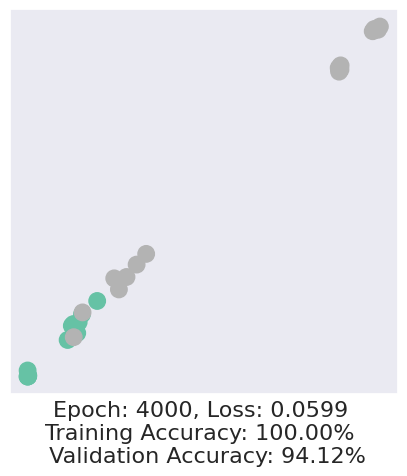

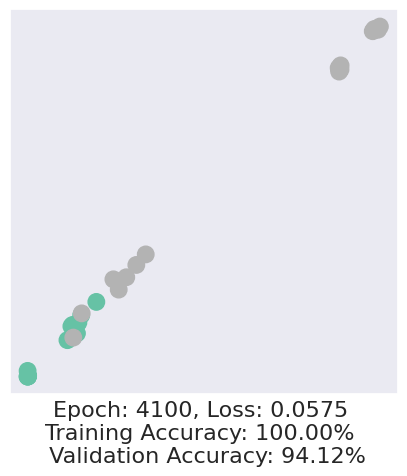

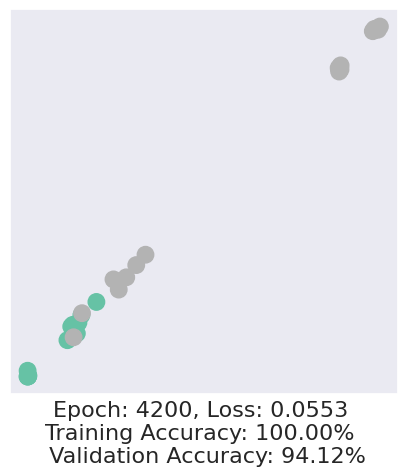

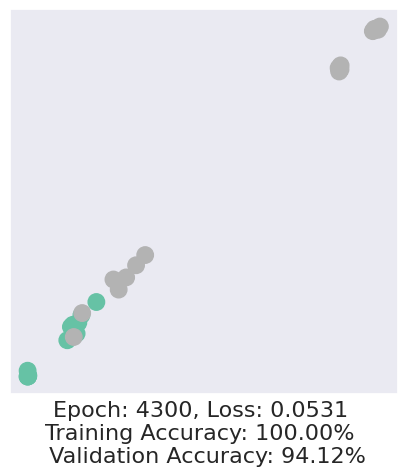

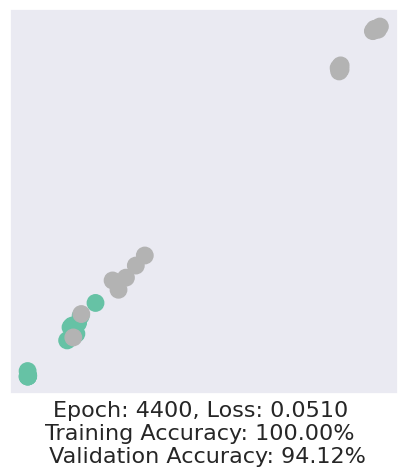

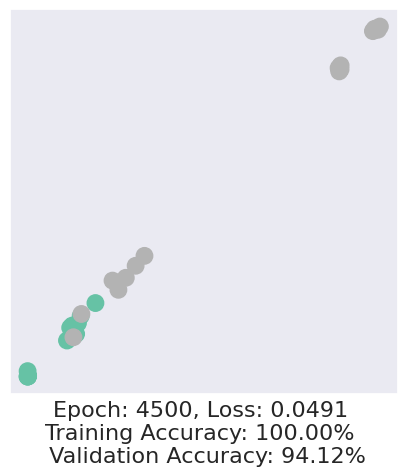

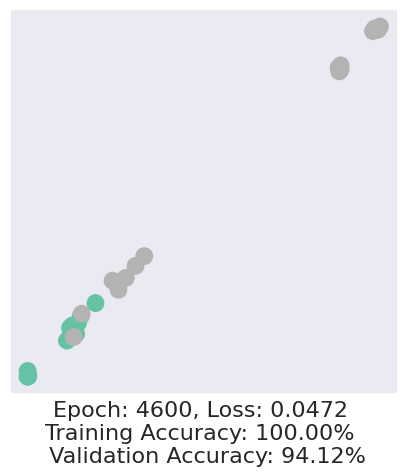

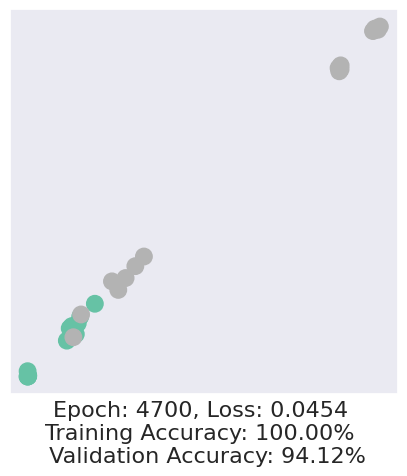

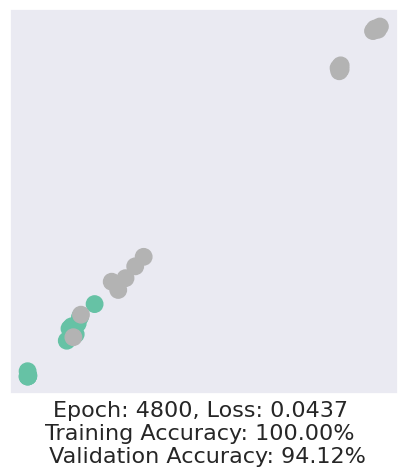

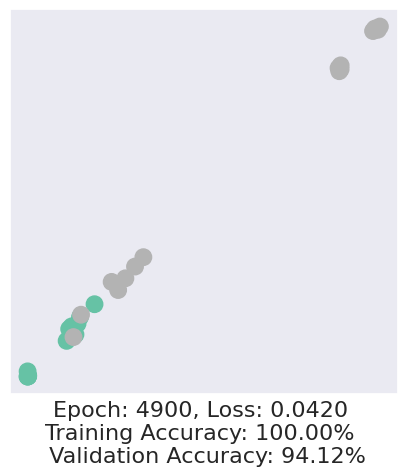

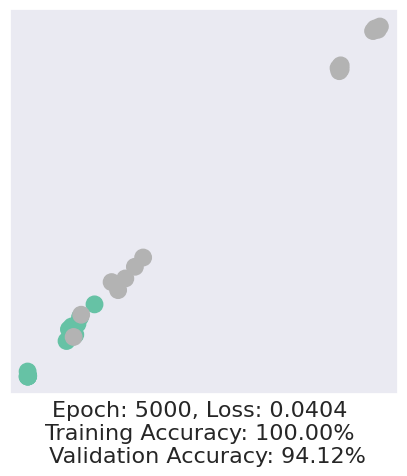

In [428]:
model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.

    accuracy = {}
    # Calculate training accuracy on our four examples
    predicted_classes_train = torch.argmax(out[data.train_mask], axis=1) # [0.6, 0.2, 0.7, 0.1] -> 2
    target_classes = data.y[data.train_mask]
    accuracy['train'] = torch.mean(
        torch.where(predicted_classes_train == target_classes, 1, 0).float())
    
    # Calculate validation accuracy on the whole graph
    predicted_classes_val = torch.argmax(out, axis=1)
    target_classes = data.y
    accuracy['val'] = torch.mean(
        torch.where(predicted_classes_val == target_classes, 1, 0).float())

    return loss, h, accuracy, out

losses = []
val_accuracies = []
train_accuracies = []
outputs = []
embeddings = []
num_of_epochs = 5001
for epoch in range(num_of_epochs):
    loss, h, accuracy, out = train(data)
    # Visualize the node embeddings every 10 epochs
    if epoch % 100 == 0:
        visualize(h, color=data.y, epoch=epoch, loss=loss, accuracy=accuracy)
    losses.append(loss)
    train_accuracies.append(accuracy["train"])
    val_accuracies.append(accuracy["val"])
    embeddings.append(h)
    outputs.append(out.argmax(axis=1))

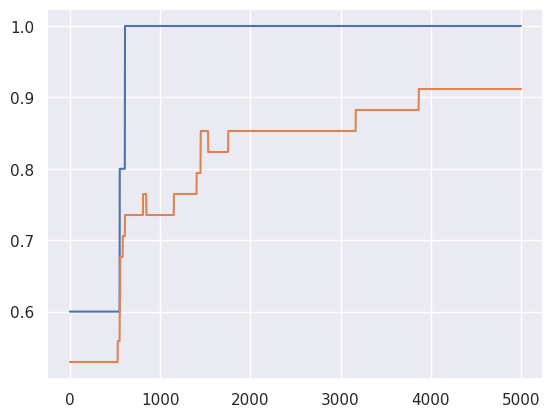

In [416]:
plt.plot(list(range(num_of_epochs)), train_accuracies)
plt.plot(list(range(num_of_epochs)), val_accuracies)

In [180]:
# %%capture
# from matplotlib import animation
# from IPython.display import HTML

# plt.rcParams["animation.bitrate"] = 3000


# def animate(i):
#     # G = tg.utils.to_networkx(data, to_undirected=True)
#     nx.draw(
#         G,
#         pos=nx.spring_layout(G, seed=10),
#         with_labels=True,
#         node_size=800,
#         node_color=outputs[i],
#         cmap="hsv",
#         vmin=-2,
#         vmax=3,
#         width=0.8,
#         font_size=14,
#     )
#     plt.title(
#         f"Epoch {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%",
#         fontsize=18,
#         pad=20,
#     )


# fig = plt.figure(figsize=(7, 7))
# plt.axis("off")

# anim = animation.FuncAnimation(
#     fig,
#     animate,
#     np.arange(0, 200, 10),
#     interval=500,
#     repeat=True,
# )

# html = HTML(anim.to_html5_video())

In [181]:
# display(html)

In [418]:
def visualize_network(outputs, losses, accuracies):
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 8), squeeze=0)

    for i, ax in enumerate(axes.flatten()):
        i = i * 1000
        nx.draw(
            G,
            pos=nx.spring_layout(G, seed=10),
            with_labels=True,
            node_size=800,
            node_color=outputs[i],
            cmap="hsv",
            vmin=-2,
            vmax=3,
            width=0.8,
            font_size=14,
            ax=ax,
        )
        ax.set_title(
            f"Epoch = {i}\nloss = {losses[i]:0.4f}\naccuracy = {accuracies[i]:0.4f}"
        )
        # ax.set_axis_off()


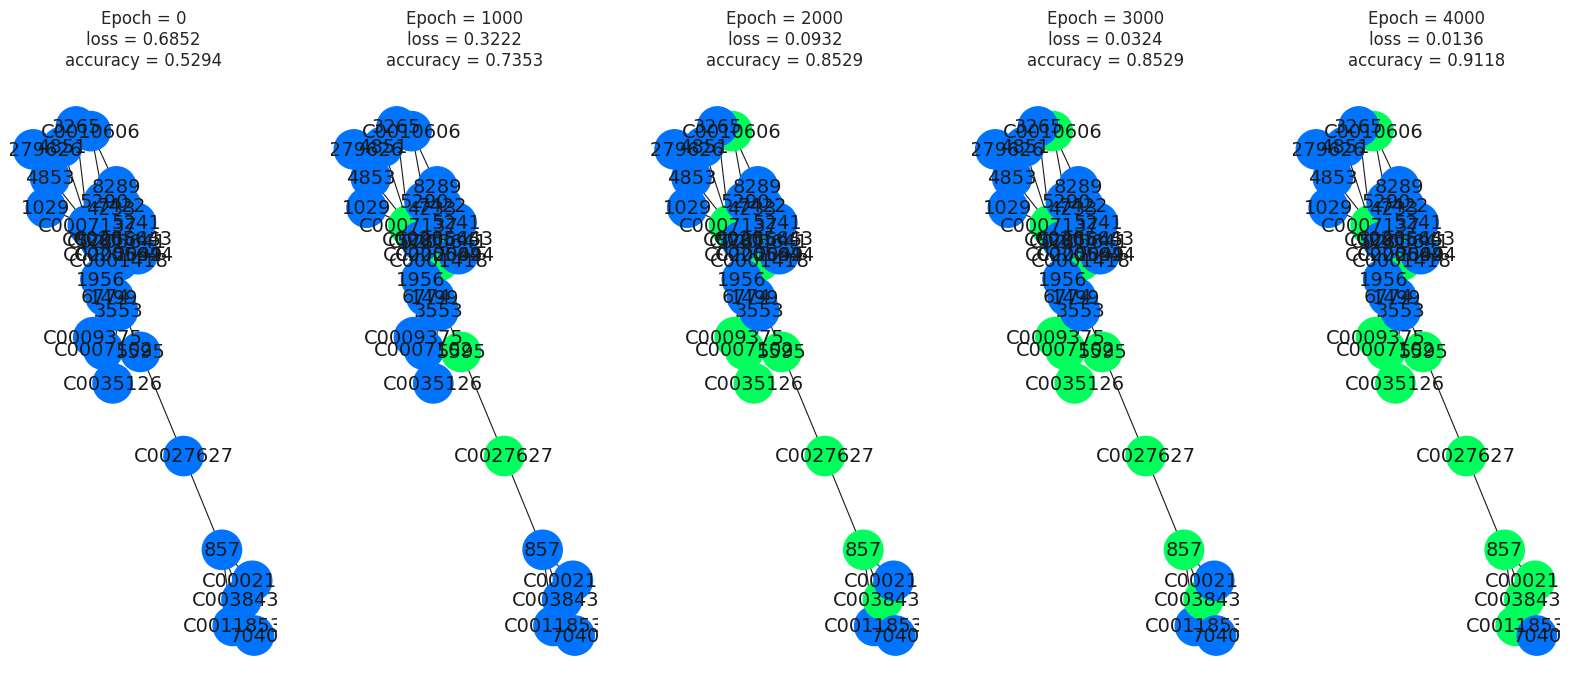

In [419]:
visualize_network(outputs, losses, val_accuracies)

In [394]:
(data.train_mask == True).nonzero()[:, 0]

tensor([ 7, 15, 30, 31, 32])

In [395]:
data.node_stores[0]["y"][data.train_mask]

tensor([0, 0, 1, 1, 1])

In [183]:
# %%capture
# def animate(i):
#     embed = embeddings[i].detach().cpu().numpy()
#     ax.clear()
#     ax.scatter(
#         embed[:, 0],
#         embed[:, 1],
#         embed[:, 2],
#         s=200,
#         c=data.y,
#         cmap="hsv",
#         vmin=-2,
#         vmax=3,
#     )
#     plt.title(
#         f"Epoch {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%",
#         fontsize=18,
#         pad=40,
#     )


# fig = plt.figure(figsize=(8, 8))
# plt.axis("off")
# ax = fig.add_subplot(projection="3d")
# plt.tick_params(
#     left=False,
#     bottom=False,
#     labelleft=False,
#     labelbottom=False,
# )


# anim = animation.FuncAnimation(
#     fig,
#     animate,
#     np.arange(0, 200, 10),
#     interval=800,
#     repeat=True,
# )
# html = HTML(anim.to_html5_video())


In [184]:
# display(html)

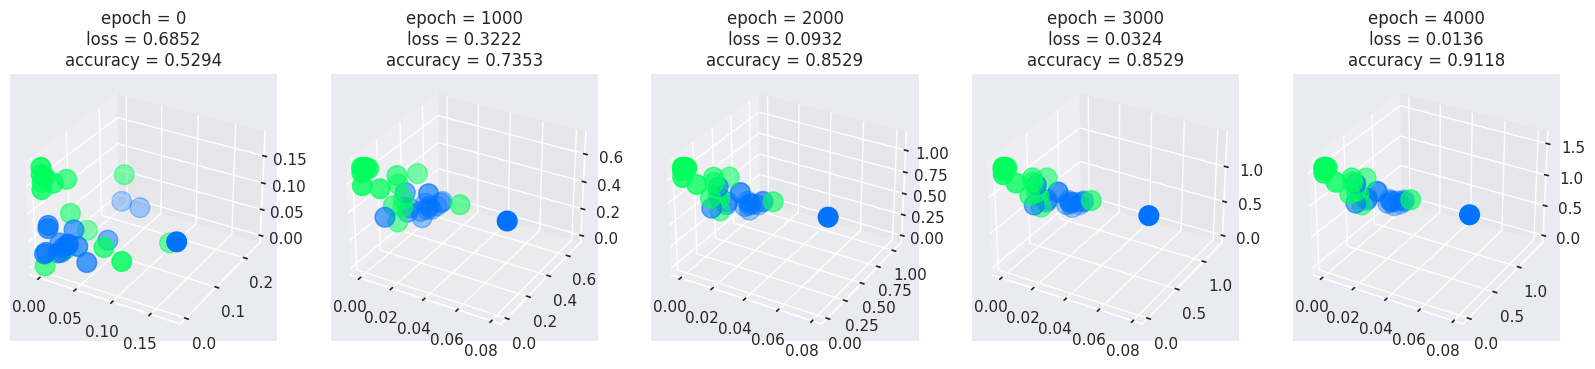

In [422]:
fig = plt.figure(figsize=(20, 8))


for i in range(5):
    # i = i * 50
    ind = i * 1000

    ax = fig.add_subplot(1, 5, i + 1, projection="3d")

    embed = embeddings[ind].detach().cpu().numpy()
    ax.clear()
    ax.scatter(
        embed[:, 0],
        embed[:, 1],
        embed[:, 2],
        s=200,
        c=data.y,
        cmap="hsv",
        vmin=-2,
        vmax=3,
    )

    ax.set_title(
        f"epoch = {ind}\nloss = {losses[ind]:0.4f}\naccuracy = {val_accuracies[ind]:0.4f}"
    )
    # ax.tick_params(
    #     left=False,
    #     bottom=False,
    #     labelleft=False,
    #     labelbottom=False,
    # )


### Experiment with layers

In [187]:
def train(model, criterion, optimizer, epoch):
    # Data for animations
    embeddings = []
    losses = []
    accuracies = []
    outputs = []

    # Training loop
    for epoch in range(epoch+1):
        # Clear gradients
        optimizer.zero_grad()

        # Forward pass
        h, z = model(data.x, data.edge_index)

        # Calculate loss function
        loss = criterion(z, data.y)

        # Calculate accuracy
        acc = accuracy(z.argmax(dim=1), data.y)

        # Compute gradients
        loss.backward()

        # Tune parameters
        optimizer.step()

        # Store data for animations
        embeddings.append(h)
        losses.append(loss)
        accuracies.append(acc)
        outputs.append(z.argmax(dim=1))

        # Print metrics every 10 epochs
        if epoch % 10 == 0:
            print(f"Epoch {epoch:>4} | Loss: {loss} | Acc: {acc*100}%")

    return embeddings, losses, accuracies, outputs

In [202]:
criterion2 = torch.nn.CrossEntropyLoss()
optimizer2 = torch.optim.Adam(model.parameters(), lr=0.02)

In [203]:
train(model2, criterion2, optimizer2, 200)

Epoch    0 | Loss: 0.7140241861343384 | Acc: 47.05882263183594%
Epoch   10 | Loss: 0.7140241861343384 | Acc: 47.05882263183594%
Epoch   20 | Loss: 0.7140241861343384 | Acc: 47.05882263183594%
Epoch   30 | Loss: 0.7140241861343384 | Acc: 47.05882263183594%
Epoch   40 | Loss: 0.7140241861343384 | Acc: 47.05882263183594%
Epoch   50 | Loss: 0.7140241861343384 | Acc: 47.05882263183594%
Epoch   60 | Loss: 0.7140241861343384 | Acc: 47.05882263183594%
Epoch   70 | Loss: 0.7140241861343384 | Acc: 47.05882263183594%
Epoch   80 | Loss: 0.7140241861343384 | Acc: 47.05882263183594%
Epoch   90 | Loss: 0.7140241861343384 | Acc: 47.05882263183594%
Epoch  100 | Loss: 0.7140241861343384 | Acc: 47.05882263183594%
Epoch  110 | Loss: 0.7140241861343384 | Acc: 47.05882263183594%
Epoch  120 | Loss: 0.7140241861343384 | Acc: 47.05882263183594%
Epoch  130 | Loss: 0.7140241861343384 | Acc: 47.05882263183594%
Epoch  140 | Loss: 0.7140241861343384 | Acc: 47.05882263183594%
Epoch  150 | Loss: 0.7140241861343384 | 

([tensor([[-0.2700, -0.2837],
          [-0.2764, -0.2820],
          [-0.2779, -0.2665],
          [-0.2687, -0.2489],
          [-0.2700, -0.2837],
          [-0.2700, -0.2838],
          [-0.2726, -0.2692],
          [-0.2701, -0.2836],
          [-0.2787, -0.2671],
          [-0.2701, -0.2836],
          [-0.2774, -0.2671],
          [-0.2701, -0.2837],
          [-0.2752, -0.2792],
          [-0.2844, -0.2644],
          [-0.2792, -0.2740],
          [-0.2901, -0.2868],
          [-0.2830, -0.2339],
          [-0.2728, -0.2680],
          [-0.2808, -0.2234],
          [-0.2738, -0.2479],
          [-0.2819, -0.2314],
          [-0.2790, -0.2426],
          [-0.2919, -0.2700],
          [-0.2819, -0.2314],
          [-0.2789, -0.2264],
          [-0.2827, -0.2299],
          [-0.2770, -0.2730],
          [-0.2921, -0.2461],
          [-0.2788, -0.2233],
          [-0.2764, -0.2393],
          [-0.2820, -0.2358],
          [-0.2821, -0.2356],
          [-0.2809, -0.2265],
          